## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp008'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    #backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnet152'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

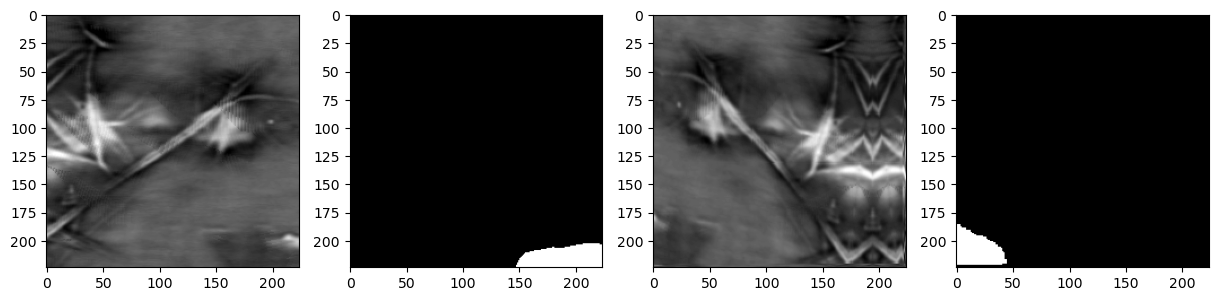

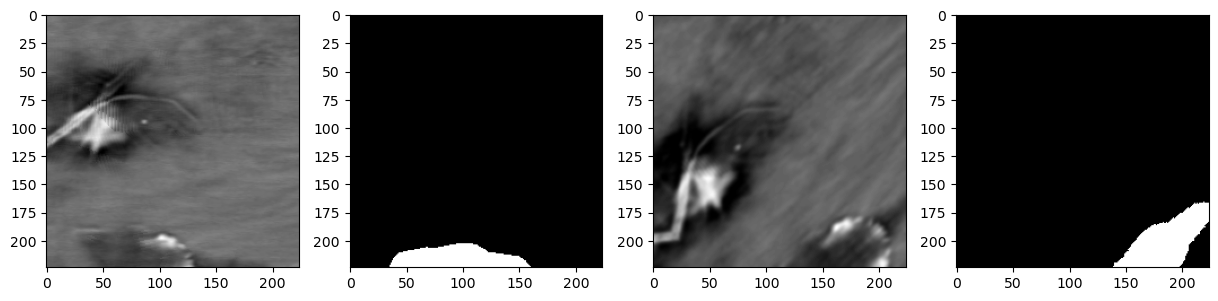

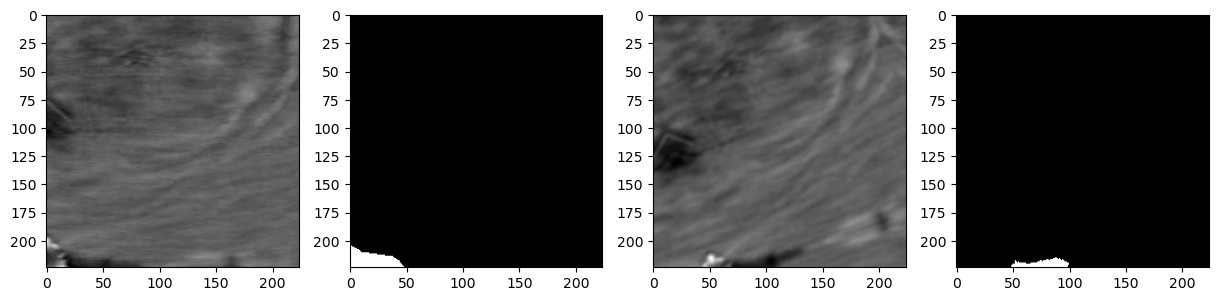

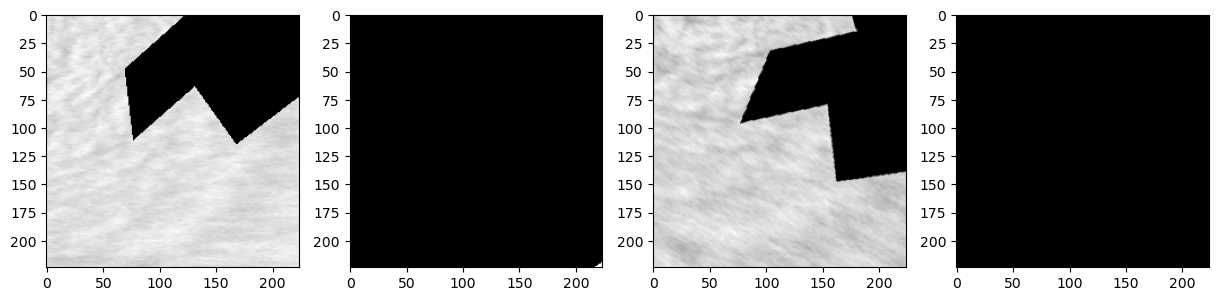

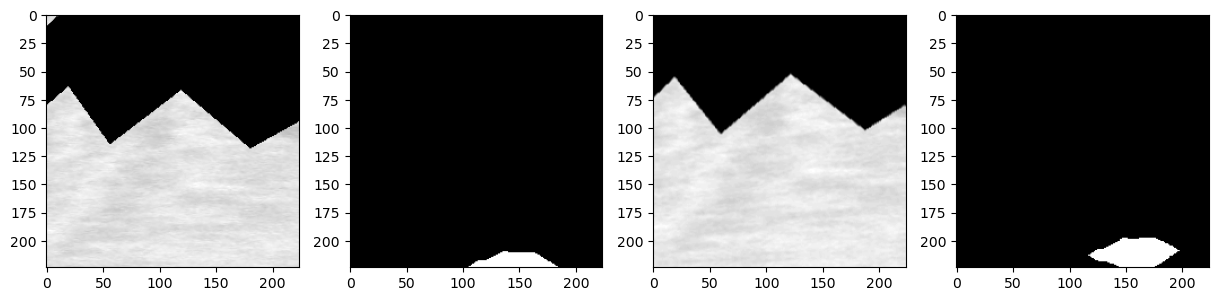

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48125

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnet152


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth" to /root/.cache/torch/hub/checkpoints/se_resnet152-d17c99b7.pth


  0%|          | 0.00/256M [00:00<?, ?B/s]

## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096641683249357
th: 0.15, fbeta: 0.12098238310317236
th: 0.2, fbeta: 0.19797904295391905
th: 0.25, fbeta: 0.21117212705926078
th: 0.3, fbeta: 0.23466197814631182
th: 0.35, fbeta: 0.2870283210970558
th: 0.4, fbeta: 0.34197810802991485
th: 0.45, fbeta: 0.3827505996122642


best_th: 0.5, fbeta: 0.4022967423216816
Epoch 1 - avg_train_loss: 0.6111  avg_val_loss: 0.4091  time: 254s
Epoch 1 - avgScore: 0.4023
Epoch 1 - Save Best Score: 0.4023 Model
Epoch 1 - Save Best Loss: 0.4091 Model


th: 0.5, fbeta: 0.4022967423216816


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.16226648957699039
th: 0.15, fbeta: 0.22797018741527517
th: 0.2, fbeta: 0.24455806143538344
th: 0.25, fbeta: 0.2931073414432195
th: 0.3, fbeta: 0.3436227841027801
th: 0.35, fbeta: 0.3871497186702275
th: 0.4, fbeta: 0.42170224496649533
th: 0.45, fbeta: 0.45068506628606486


best_th: 0.5, fbeta: 0.4694979148726463
Epoch 2 - avg_train_loss: 0.3687  avg_val_loss: 0.3158  time: 260s
Epoch 2 - avgScore: 0.4695
Epoch 2 - Save Best Score: 0.4695 Model
Epoch 2 - Save Best Loss: 0.3158 Model


th: 0.5, fbeta: 0.4694979148726463


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.25297936140201116
th: 0.15, fbeta: 0.28306223728711105
th: 0.2, fbeta: 0.31300494746095125
th: 0.25, fbeta: 0.34942206524894404
th: 0.3, fbeta: 0.37938759490326784
th: 0.35, fbeta: 0.40536074171601344
th: 0.4, fbeta: 0.42499768619192146
th: 0.45, fbeta: 0.43700124629942017


best_th: 0.5, fbeta: 0.4462598944704033
Epoch 3 - avg_train_loss: 0.2812  avg_val_loss: 0.2591  time: 260s
Epoch 3 - avgScore: 0.4463


th: 0.5, fbeta: 0.4462598944704033


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29539793507995377
th: 0.15, fbeta: 0.3183837621421868
th: 0.2, fbeta: 0.33882468268686494
th: 0.25, fbeta: 0.35688529703899724
th: 0.3, fbeta: 0.37363631077978315
th: 0.35, fbeta: 0.3908702340058373
th: 0.4, fbeta: 0.40890319212968756
th: 0.45, fbeta: 0.42634517916653625


best_th: 0.5, fbeta: 0.4410960279398744
Epoch 4 - avg_train_loss: 0.2512  avg_val_loss: 0.2681  time: 258s
Epoch 4 - avgScore: 0.4411


th: 0.5, fbeta: 0.4410960279398744


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3392922196491148
th: 0.15, fbeta: 0.3896354623607404
th: 0.2, fbeta: 0.42322992539031984
th: 0.25, fbeta: 0.4480662283042216
th: 0.3, fbeta: 0.46758948386334404
th: 0.35, fbeta: 0.48195159372337254
th: 0.4, fbeta: 0.4908468927797049
th: 0.45, fbeta: 0.49758123412080624


best_th: 0.5, fbeta: 0.5008510160765943
Epoch 5 - avg_train_loss: 0.2412  avg_val_loss: 0.2307  time: 255s
Epoch 5 - avgScore: 0.5009
Epoch 5 - Save Best Score: 0.5009 Model
Epoch 5 - Save Best Loss: 0.2307 Model


th: 0.5, fbeta: 0.5008510160765943


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3527171288719093
th: 0.15, fbeta: 0.3874222618840631
th: 0.2, fbeta: 0.4114077353695951
th: 0.25, fbeta: 0.42431636714717635
th: 0.3, fbeta: 0.4276488681160642
th: 0.35, fbeta: 0.42158143765445527
th: 0.4, fbeta: 0.41455672827164863
th: 0.45, fbeta: 0.4000362564067255


best_th: 0.3, fbeta: 0.4276488681160642
Epoch 6 - avg_train_loss: 0.2338  avg_val_loss: 0.2560  time: 259s
Epoch 6 - avgScore: 0.4276


th: 0.5, fbeta: 0.3785275815478238


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37045582399107513
th: 0.15, fbeta: 0.42205357353500056
th: 0.2, fbeta: 0.4596741754747472
th: 0.25, fbeta: 0.4839152619334207
th: 0.3, fbeta: 0.5020326259694904
th: 0.35, fbeta: 0.509753829076915
th: 0.4, fbeta: 0.5107703041660854
th: 0.45, fbeta: 0.5032031310448664


best_th: 0.4, fbeta: 0.5107703041660854
Epoch 7 - avg_train_loss: 0.2261  avg_val_loss: 0.2330  time: 255s
Epoch 7 - avgScore: 0.5108
Epoch 7 - Save Best Score: 0.5108 Model
Epoch 7 - Save Best Loss: 0.2330 Model


th: 0.5, fbeta: 0.4835293770264964


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3604046779877212
th: 0.15, fbeta: 0.4070530801979644
th: 0.2, fbeta: 0.43891521990560206
th: 0.25, fbeta: 0.4659614091078894
th: 0.3, fbeta: 0.4880160361780488
th: 0.35, fbeta: 0.5071642485115437
th: 0.4, fbeta: 0.5214064679574757
th: 0.45, fbeta: 0.5321882211084986


best_th: 0.5, fbeta: 0.539865001495801
Epoch 8 - avg_train_loss: 0.2196  avg_val_loss: 0.2244  time: 258s
Epoch 8 - avgScore: 0.5399
Epoch 8 - Save Best Score: 0.5399 Model
Epoch 8 - Save Best Loss: 0.2244 Model


th: 0.5, fbeta: 0.539865001495801


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3541470436355692
th: 0.15, fbeta: 0.3815831379899249
th: 0.2, fbeta: 0.390629029303317
th: 0.25, fbeta: 0.3801195047427155
th: 0.3, fbeta: 0.36150432543357036
th: 0.35, fbeta: 0.33709300429888833
th: 0.4, fbeta: 0.3064178325253237
th: 0.45, fbeta: 0.2744660879817718


best_th: 0.2, fbeta: 0.390629029303317
Epoch 9 - avg_train_loss: 0.2132  avg_val_loss: 0.3030  time: 259s
Epoch 9 - avgScore: 0.3906


th: 0.5, fbeta: 0.2379728518951545


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3989110065389652
th: 0.15, fbeta: 0.4333628635772036
th: 0.2, fbeta: 0.4583195887399548
th: 0.25, fbeta: 0.4762073739184509
th: 0.3, fbeta: 0.4932167177782075
th: 0.35, fbeta: 0.5059696065260875
th: 0.4, fbeta: 0.5090076630501568
th: 0.45, fbeta: 0.5069636835394917


best_th: 0.4, fbeta: 0.5090076630501568
Epoch 10 - avg_train_loss: 0.2075  avg_val_loss: 0.2371  time: 259s
Epoch 10 - avgScore: 0.5090


th: 0.5, fbeta: 0.5007545073631372


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33141845629650796
th: 0.15, fbeta: 0.35496745133668384
th: 0.2, fbeta: 0.37829495482491676
th: 0.25, fbeta: 0.3989334280236827
th: 0.3, fbeta: 0.4156402963037273
th: 0.35, fbeta: 0.428550445593236
th: 0.4, fbeta: 0.43823704150895265
th: 0.45, fbeta: 0.4452668423370638


best_th: 0.5, fbeta: 0.44944607548278
Epoch 11 - avg_train_loss: 0.2007  avg_val_loss: 0.2538  time: 259s
Epoch 11 - avgScore: 0.4494


th: 0.5, fbeta: 0.44944607548278


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.407653369638958
th: 0.15, fbeta: 0.4346570862787381
th: 0.2, fbeta: 0.45121515905597115
th: 0.25, fbeta: 0.4627113799379876
th: 0.3, fbeta: 0.4719114676110059
th: 0.35, fbeta: 0.48012356916149423
th: 0.4, fbeta: 0.48461455016332916
th: 0.45, fbeta: 0.4848554667834647


best_th: 0.45, fbeta: 0.4848554667834647
Epoch 12 - avg_train_loss: 0.1942  avg_val_loss: 0.2820  time: 258s
Epoch 12 - avgScore: 0.4849


th: 0.5, fbeta: 0.4809862574832724


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3978957158235917
th: 0.15, fbeta: 0.44422939246917326
th: 0.2, fbeta: 0.477828818984064
th: 0.25, fbeta: 0.5000246320485107
th: 0.3, fbeta: 0.5186225543500427
th: 0.35, fbeta: 0.5347761829542792
th: 0.4, fbeta: 0.5478688658706239
th: 0.45, fbeta: 0.5580010479710287


best_th: 0.5, fbeta: 0.56162121767129
Epoch 13 - avg_train_loss: 0.1826  avg_val_loss: 0.2394  time: 260s
Epoch 13 - avgScore: 0.5616
Epoch 13 - Save Best Score: 0.5616 Model
Epoch 13 - Save Best Loss: 0.2394 Model


th: 0.5, fbeta: 0.56162121767129


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3645247753677091
th: 0.15, fbeta: 0.4013395620598895
th: 0.2, fbeta: 0.4304300198813909
th: 0.25, fbeta: 0.45500332372568214
th: 0.3, fbeta: 0.47494155446194714
th: 0.35, fbeta: 0.4876977794815468
th: 0.4, fbeta: 0.4977544604476855
th: 0.45, fbeta: 0.5082094220159864


best_th: 0.5, fbeta: 0.5150754022965124
Epoch 14 - avg_train_loss: 0.1772  avg_val_loss: 0.2448  time: 261s
Epoch 14 - avgScore: 0.5151


th: 0.5, fbeta: 0.5150754022965124


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31623804026913194
th: 0.15, fbeta: 0.3350534771829537
th: 0.2, fbeta: 0.35223085261332454
th: 0.25, fbeta: 0.3668259370517597
th: 0.3, fbeta: 0.3812926424891166
th: 0.35, fbeta: 0.39509214613445126
th: 0.4, fbeta: 0.4083348120994499
th: 0.45, fbeta: 0.42208602732680284


best_th: 0.5, fbeta: 0.4340320349708008
Epoch 15 - avg_train_loss: 0.1696  avg_val_loss: 0.2971  time: 259s
Epoch 15 - avgScore: 0.4340


th: 0.5, fbeta: 0.4340320349708008


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3779777420898618
th: 0.15, fbeta: 0.40642161949166
th: 0.2, fbeta: 0.4274855235603424
th: 0.25, fbeta: 0.4462742713794276
th: 0.3, fbeta: 0.4610780873348441
th: 0.35, fbeta: 0.4739665393810658
th: 0.4, fbeta: 0.48577373503272314
th: 0.45, fbeta: 0.49402576856199437


best_th: 0.5, fbeta: 0.4990631658246685
Epoch 16 - avg_train_loss: 0.1607  avg_val_loss: 0.2798  time: 260s
Epoch 16 - avgScore: 0.4991


th: 0.5, fbeta: 0.4990631658246685


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3686141998161075
th: 0.15, fbeta: 0.39383190974681953
th: 0.2, fbeta: 0.4142568268899356
th: 0.25, fbeta: 0.43118150487362805
th: 0.3, fbeta: 0.44655808222467536
th: 0.35, fbeta: 0.4603778131051386
th: 0.4, fbeta: 0.47268770491726814
th: 0.45, fbeta: 0.4847141104978945


best_th: 0.5, fbeta: 0.49901528512707716
Epoch 17 - avg_train_loss: 0.1538  avg_val_loss: 0.2777  time: 260s
Epoch 17 - avgScore: 0.4990


th: 0.5, fbeta: 0.49901528512707716


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40829350831094136
th: 0.15, fbeta: 0.43626808222664065
th: 0.2, fbeta: 0.45977728157123254
th: 0.25, fbeta: 0.4781260826279574
th: 0.3, fbeta: 0.4928512067746252
th: 0.35, fbeta: 0.5025608871801301
th: 0.4, fbeta: 0.5098368705084397
th: 0.45, fbeta: 0.514518410976206


best_th: 0.5, fbeta: 0.5164507779310515
Epoch 18 - avg_train_loss: 0.1475  avg_val_loss: 0.2831  time: 260s
Epoch 18 - avgScore: 0.5165


th: 0.5, fbeta: 0.5164507779310515


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4147785019389013
th: 0.15, fbeta: 0.4439046310081149
th: 0.2, fbeta: 0.46753867163452834
th: 0.25, fbeta: 0.48201262986612214
th: 0.3, fbeta: 0.4898632098210413
th: 0.35, fbeta: 0.4968821813314126
th: 0.4, fbeta: 0.5030469256510607
th: 0.45, fbeta: 0.5077754198070702


best_th: 0.5, fbeta: 0.5091896312588959
Epoch 19 - avg_train_loss: 0.1391  avg_val_loss: 0.2934  time: 257s
Epoch 19 - avgScore: 0.5092


th: 0.5, fbeta: 0.5091896312588959


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4078131445233266
th: 0.15, fbeta: 0.43451868039914165
th: 0.2, fbeta: 0.45544522180477875
th: 0.25, fbeta: 0.4716294569000394
th: 0.3, fbeta: 0.4870178916400993
th: 0.35, fbeta: 0.49996312950921623
th: 0.4, fbeta: 0.5093582897614939
th: 0.45, fbeta: 0.512726272993358


best_th: 0.45, fbeta: 0.512726272993358
Epoch 20 - avg_train_loss: 0.1333  avg_val_loss: 0.3125  time: 256s
Epoch 20 - avgScore: 0.5127


th: 0.5, fbeta: 0.5104174798470319


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38928473260073604
th: 0.15, fbeta: 0.41081350928599913
th: 0.2, fbeta: 0.4249175681670373
th: 0.25, fbeta: 0.4350960109288129
th: 0.3, fbeta: 0.4448014420144947
th: 0.35, fbeta: 0.4536127668278338
th: 0.4, fbeta: 0.4600169438967339
th: 0.45, fbeta: 0.4629242522393113


best_th: 0.45, fbeta: 0.4629242522393113
Epoch 21 - avg_train_loss: 0.1266  avg_val_loss: 0.3254  time: 258s
Epoch 21 - avgScore: 0.4629


th: 0.5, fbeta: 0.4621399301474756


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3860403921226861
th: 0.15, fbeta: 0.40972195975041686
th: 0.2, fbeta: 0.4287869966398871
th: 0.25, fbeta: 0.4423155082803738
th: 0.3, fbeta: 0.4530486073864767
th: 0.35, fbeta: 0.4625967795071328
th: 0.4, fbeta: 0.4704629520828185
th: 0.45, fbeta: 0.4749404079463816


best_th: 0.45, fbeta: 0.4749404079463816
Epoch 22 - avg_train_loss: 0.1210  avg_val_loss: 0.3265  time: 257s
Epoch 22 - avgScore: 0.4749


th: 0.5, fbeta: 0.47422614140073793


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4248474535292334
th: 0.15, fbeta: 0.43722889352849104
th: 0.2, fbeta: 0.446166075592228
th: 0.25, fbeta: 0.45248145480748964
th: 0.3, fbeta: 0.45926903789779977
th: 0.35, fbeta: 0.46381130193109743
th: 0.4, fbeta: 0.4675574957449017
th: 0.45, fbeta: 0.46893815277299544


best_th: 0.45, fbeta: 0.46893815277299544
Epoch 23 - avg_train_loss: 0.1158  avg_val_loss: 0.3680  time: 257s
Epoch 23 - avgScore: 0.4689


th: 0.5, fbeta: 0.4672844134089476


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41581482980843404
th: 0.15, fbeta: 0.4397604189486644
th: 0.2, fbeta: 0.4577927580829422
th: 0.25, fbeta: 0.4708926788766122
th: 0.3, fbeta: 0.4803026781859565
th: 0.35, fbeta: 0.4864941437761438
th: 0.4, fbeta: 0.49009242893830884
th: 0.45, fbeta: 0.4916810038891418


best_th: 0.5, fbeta: 0.49180342670969746
Epoch 24 - avg_train_loss: 0.1104  avg_val_loss: 0.3397  time: 260s
Epoch 24 - avgScore: 0.4918


th: 0.5, fbeta: 0.49180342670969746


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.420184167231256
th: 0.15, fbeta: 0.4377463123375135
th: 0.2, fbeta: 0.4501506173063343
th: 0.25, fbeta: 0.4587161886528243
th: 0.3, fbeta: 0.4651266697833383
th: 0.35, fbeta: 0.47370354414418725
th: 0.4, fbeta: 0.4784437970652838
th: 0.45, fbeta: 0.478991297578759


best_th: 0.45, fbeta: 0.478991297578759
Epoch 25 - avg_train_loss: 0.1065  avg_val_loss: 0.3591  time: 259s
Epoch 25 - avgScore: 0.4790


th: 0.5, fbeta: 0.47693283199791275


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4249324127181468
th: 0.15, fbeta: 0.4437420501944502
th: 0.2, fbeta: 0.4568782962387797
th: 0.25, fbeta: 0.46658851531118717
th: 0.3, fbeta: 0.47197015905711387
th: 0.35, fbeta: 0.47436355772631866
th: 0.4, fbeta: 0.4779151937705536
th: 0.45, fbeta: 0.4790251827510841


best_th: 0.45, fbeta: 0.4790251827510841
Epoch 26 - avg_train_loss: 0.1033  avg_val_loss: 0.3698  time: 256s
Epoch 26 - avgScore: 0.4790


th: 0.5, fbeta: 0.4756783827222219


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4063432487086348
th: 0.15, fbeta: 0.42712813761059604
th: 0.2, fbeta: 0.4426506162496318
th: 0.25, fbeta: 0.4562620045838793
th: 0.3, fbeta: 0.4650236915122266
th: 0.35, fbeta: 0.4713680964255638
th: 0.4, fbeta: 0.47517438786009614
th: 0.45, fbeta: 0.4790875014919178


best_th: 0.5, fbeta: 0.4807873210607651
Epoch 27 - avg_train_loss: 0.0998  avg_val_loss: 0.3470  time: 261s
Epoch 27 - avgScore: 0.4808


th: 0.5, fbeta: 0.4807873210607651


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40840963825384063
th: 0.15, fbeta: 0.4297541652373939
th: 0.2, fbeta: 0.44452340971926474
th: 0.25, fbeta: 0.4533545781467946
th: 0.3, fbeta: 0.45842249675385444
th: 0.35, fbeta: 0.4620578927607924
th: 0.4, fbeta: 0.4671159582922661
th: 0.45, fbeta: 0.4716857680060793


best_th: 0.5, fbeta: 0.4736206286843167
Epoch 28 - avg_train_loss: 0.0978  avg_val_loss: 0.3678  time: 260s
Epoch 28 - avgScore: 0.4736


th: 0.5, fbeta: 0.4736206286843167


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4185930224726738
th: 0.15, fbeta: 0.43923843695539466
th: 0.2, fbeta: 0.4509586160665452
th: 0.25, fbeta: 0.45864612822265305
th: 0.3, fbeta: 0.46466513826392924
th: 0.35, fbeta: 0.4689323230862925
th: 0.4, fbeta: 0.47307119671298575
th: 0.45, fbeta: 0.47444619263711657


best_th: 0.45, fbeta: 0.47444619263711657
Epoch 29 - avg_train_loss: 0.0966  avg_val_loss: 0.3652  time: 257s
Epoch 29 - avgScore: 0.4744


th: 0.5, fbeta: 0.4724936149106326


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41164751517506065
th: 0.15, fbeta: 0.4321880830570525
th: 0.2, fbeta: 0.446065330176141
th: 0.25, fbeta: 0.45501390712777073
th: 0.3, fbeta: 0.46028058842332026
th: 0.35, fbeta: 0.4642249162552404
th: 0.4, fbeta: 0.46678542207882256
th: 0.45, fbeta: 0.469860553939219


best_th: 0.5, fbeta: 0.47090779520069503
Epoch 30 - avg_train_loss: 0.0944  avg_val_loss: 0.3668  time: 257s
Epoch 30 - avgScore: 0.4709


th: 0.5, fbeta: 0.47090779520069503


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3978957158235917
th: 0.15, fbeta: 0.44422939246917326
th: 0.2, fbeta: 0.477828818984064
th: 0.25, fbeta: 0.5000246320485107
th: 0.3, fbeta: 0.5186225543500427
th: 0.35, fbeta: 0.5347761829542792
th: 0.4, fbeta: 0.5478688658706239
th: 0.45, fbeta: 0.5580010479710287


best_th: 0.5, fbeta: 0.56162121767129


th: 0.5, fbeta: 0.56162121767129


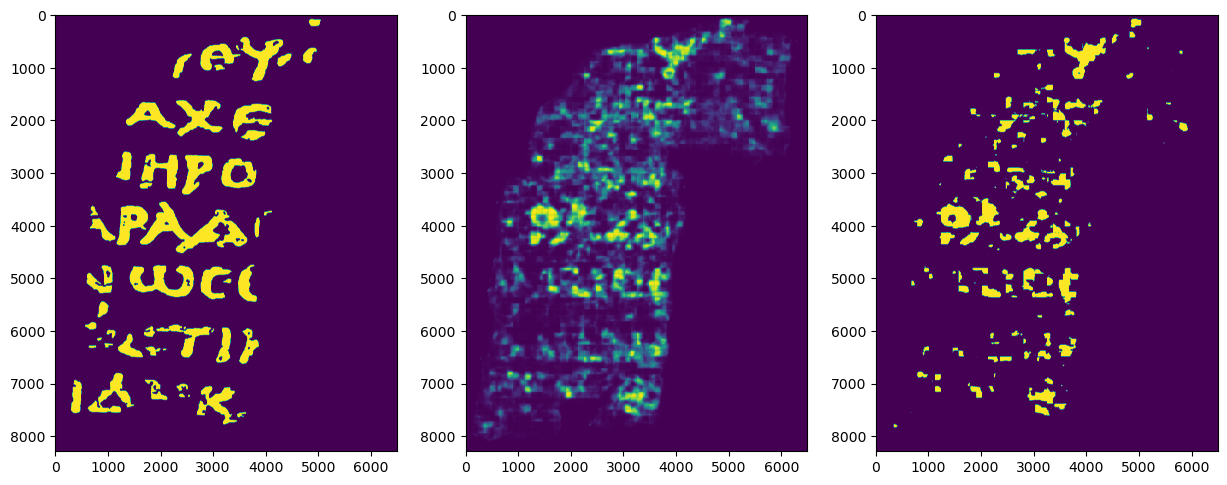

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([38414133.,  4174271.,  2403699.,  1606283.,  1159187.,   953429.,
          768514.,   632032.,   521292.,   474295.,   387586.,   337638.,
          296942.,   270288.,   263764.,   260779.,   249546.,   243377.,
          254099.,   167694.]),
 array([3.50909812e-06, 4.99462242e-02, 9.98889393e-02, 1.49831654e-01,
        1.99774369e-01, 2.49717085e-01, 2.99659800e-01, 3.49602515e-01,
        3.99545230e-01, 4.49487945e-01, 4.99430660e-01, 5.49373375e-01,
        5.99316090e-01, 6.49258805e-01, 6.99201520e-01, 7.49144236e-01,
        7.99086951e-01, 8.49029666e-01, 8.98972381e-01, 9.48915096e-01,
        9.98857811e-01]),
 <BarContainer object of 20 artists>)

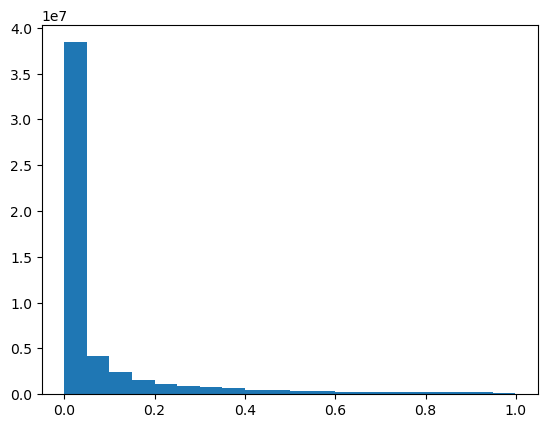

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000